In [44]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [45]:
#Basic libraries
import pandas as pd
import numpy as np

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#ML libraries
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef



#Misc libraries
import warnings
warnings.filterwarnings("ignore")

In [46]:
# Define column headers
column_names = ['step', 'transactionType', 'amount', 'startingClient', 'oldBalStartingClient', 'newBalStartingClient', 'destinationClient', 'oldBalDestinationClient', 'newBalDestinationClient', 'isFraud', 'isFlaggedFraud', 'isUnauthorizedOverdraft', 'anonymous']

In [47]:
# Chunking and processing
chunksize = 10 ** 6
df = pd.DataFrame()  # Create an empty DataFrame to store the data

for chunk in pd.read_csv('MoMTSim_20230726095946_1000_rawLog.csv', chunksize=chunksize):
    chunk.columns = column_names  # Assign the column names to the chunk
    chunk = chunk.sample(frac=1.0)  # Apply row sampling to the chunk
    df = pd.concat([df, chunk], ignore_index=True)  # Concatenate each chunk to the DataFrame

In [48]:
# Renaming cashin to deposit, cashout to withdrawal
df['transactionType'] = df['transactionType'].replace({'CASH_IN': 'DEPOSIT', 'CASH_OUT': 'WITHDRAWAL'})

In [49]:
df.head(5)

,step,transactionType,amount,startingClient,oldBalStartingClient,newBalStartingClient,destinationClient,oldBalDestinationClient,newBalDestinationClient,isFraud,isFlaggedFraud,isUnauthorizedOverdraft,anonymous
0,8,TRANSFER,19602.52,4571982980702765,614946.79,595344.27,4240938471955040,0.00,19602.52,0,0,0,1
1,37,TRANSFER,20555.84,4713891582228443,2230647.22,2210091.38,4936409688145014,51256.46,71812.30,1,0,0,1
2,21,DEPOSIT,130427.63,4805699548341765,3421143.23,3551570.87,04-0008732,62358.51,62358.51,0,0,0,0
3,13,WITHDRAWAL,73430.38,4254170453484111,3421309.20,3347878.82,52-0000551,4692.48,4692.48,0,0,0,0
4,24,PAYMENT,2726.81,4194215708044724,3811807.26,3809080.45,52-0000537,53250.36,55977.17,0,0,0,1


EDA

In [50]:
import math
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    # nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    nGraphRow = math.ceil(nCol / nGraphPerRow)  # Round up to the nearest integer
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [51]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    # Select only numeric columns for correlation computation
    numeric_columns = df.select_dtypes(include=[np.number])
    if len(numeric_columns) < 2:
        print(f'No correlation plots shown: The number of numeric columns ({len(numeric_columns)}) is less than 2')
        return

    corr = numeric_columns.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()


In [52]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    #df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [53]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 8802609 rows and 13 columns


We Choose the first 8 million rows and we visaulise them

In [54]:
# Select the first 1 million rows
subset_df = df.head(5000)

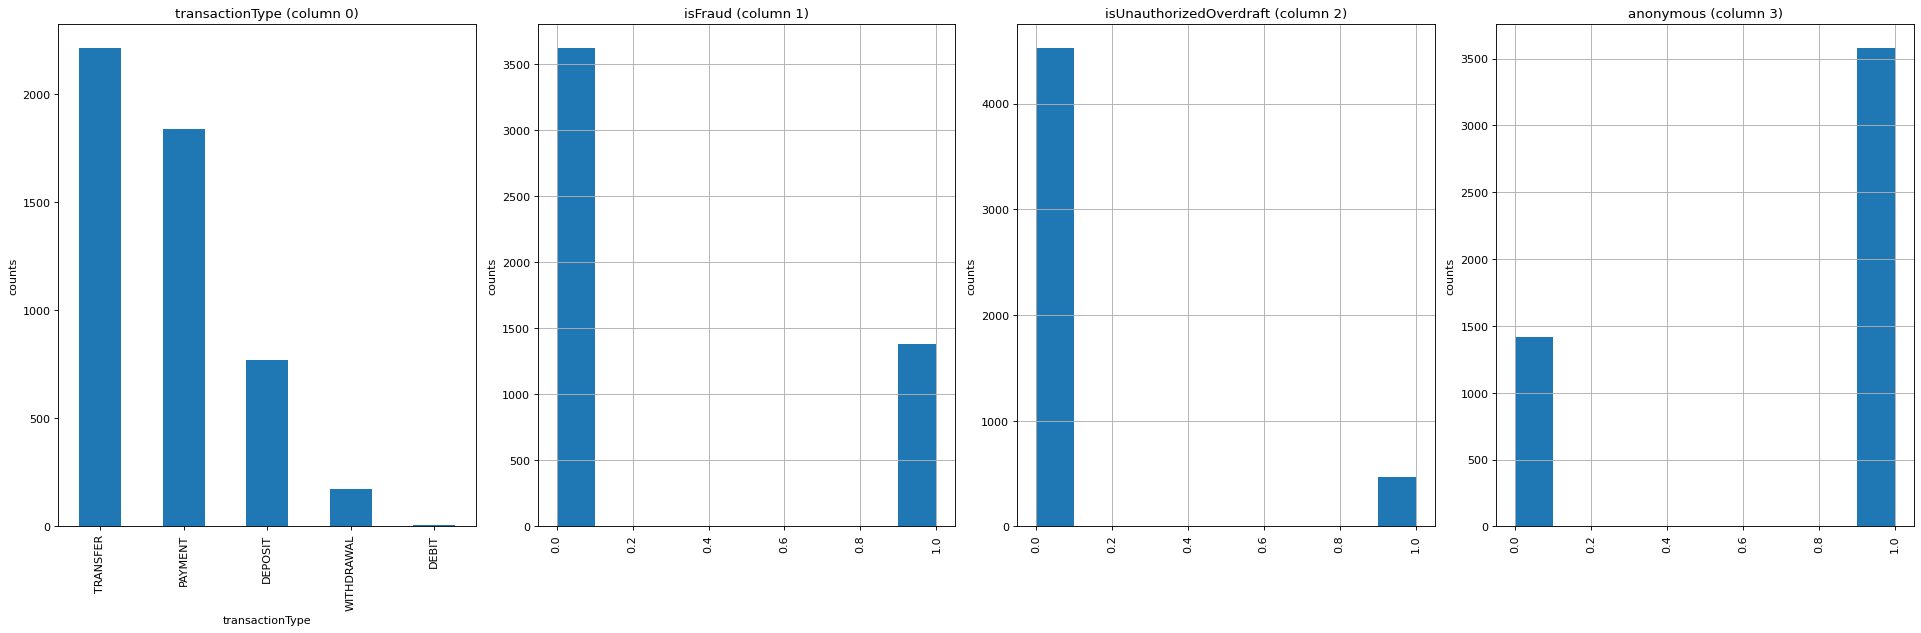

In [55]:
plotPerColumnDistribution(subset_df, 10, 15)

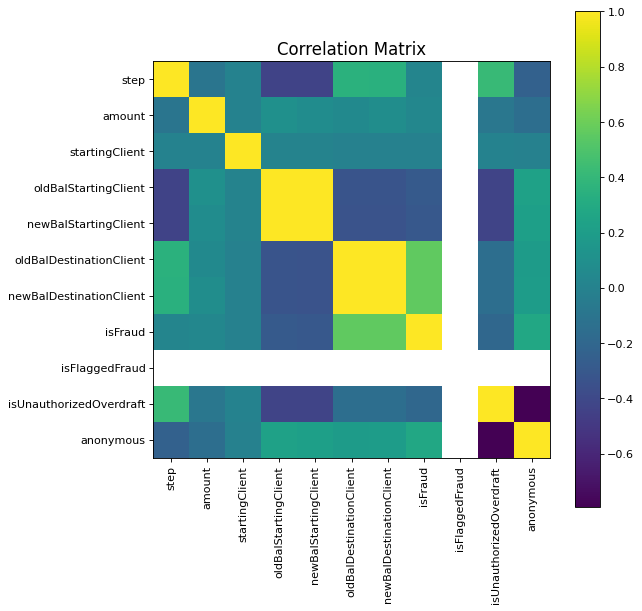

In [56]:
plotCorrelationMatrix(df, 8)

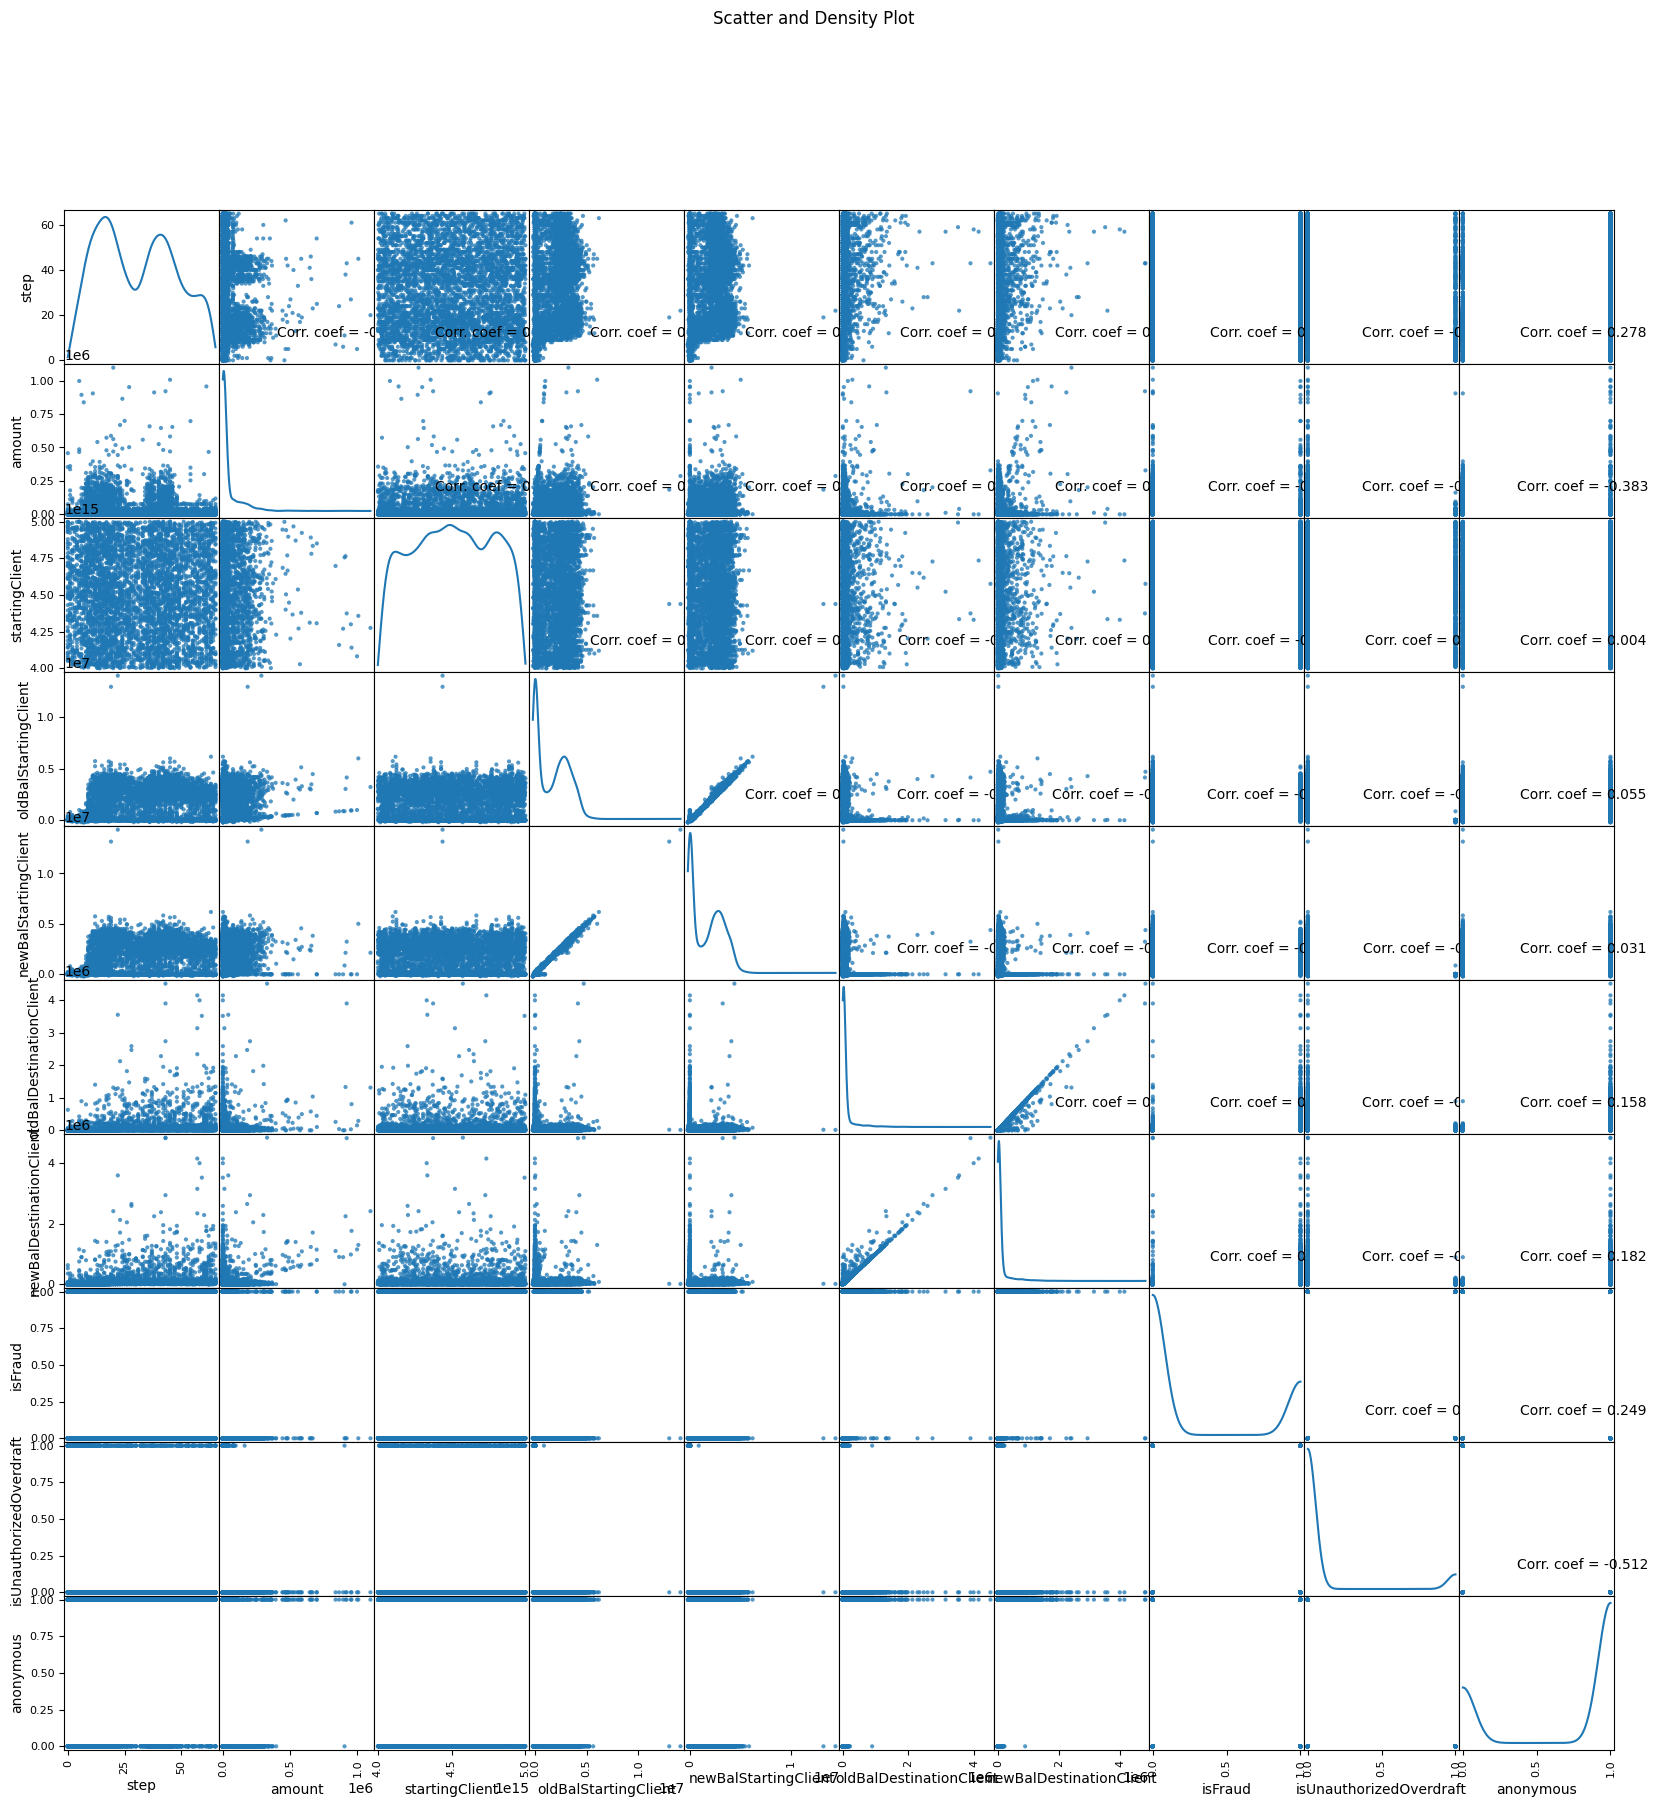

In [57]:
plotScatterMatrix(subset_df, 20, 10)

In [58]:
#Checking for balance in target
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df['isFraud'].value_counts())])
fig.show()

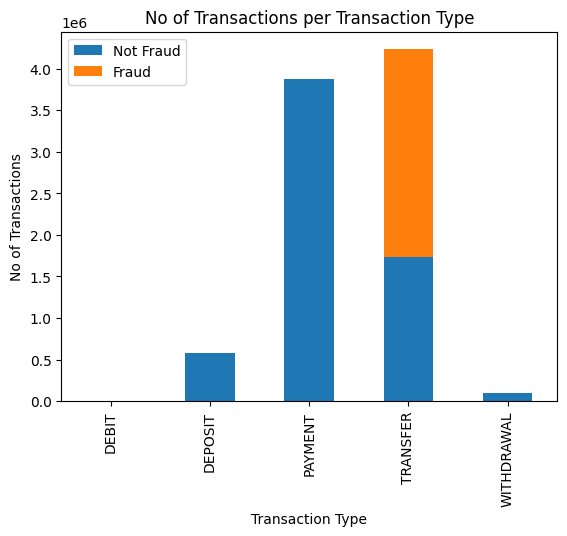

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Group the data by 'transaction_type' and 'isFraud', and count the rows
grouped_data = df.groupby(['transactionType', 'isFraud']).size().unstack()

# Plot the bar graph
ax = grouped_data.plot(kind='bar', stacked=True)

# Set the labels and title
ax.set_xlabel('Transaction Type')
ax.set_ylabel('No of Transactions')
ax.set_title('No of Transactions per Transaction Type')

# Create a legend based on the 'isFraud' column
legend_labels = ['Not Fraud', 'Fraud']
ax.legend(legend_labels)

# Show the plot
plt.show()


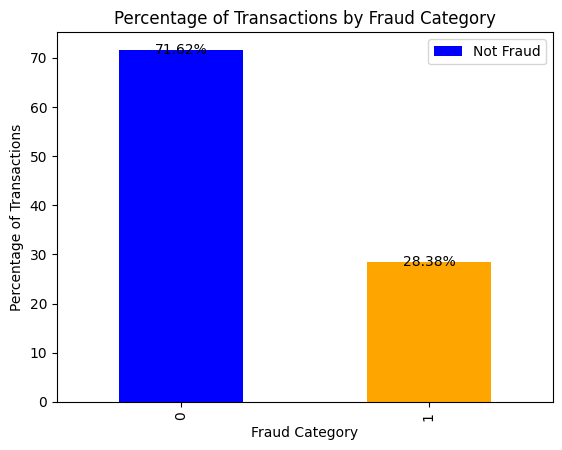

In [60]:
import matplotlib.pyplot as plt

# Group the data by 'isFraud' and calculate the proportions
grouped_data = df['isFraud'].value_counts(normalize=True) * 100

# Plot the bar graph
ax = grouped_data.sort_index().plot(kind='bar', color=['blue', 'orange'])

# Set the labels and title
ax.set_xlabel('Fraud Category')
ax.set_ylabel('Percentage of Transactions')
ax.set_title('Percentage of Transactions by Fraud Category')

# Create a legend based on the 'isFraud' column
legend_labels = ['Not Fraud', 'Fraud']  # Make sure this matches your actual data values
ax.legend(legend_labels)

# Add percentage labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

# Show the plot
plt.show()


Feature Engineering

In [61]:
# Calculate the difference between initial and final balances for customer and recipient
df['customer_balance_change'] = df['newBalStartingClient'] - df['oldBalStartingClient']
df['recipient_balance_change'] = df['newBalDestinationClient'] - df['oldBalDestinationClient']

# Calculate the difference between the transaction amount and customer balance change
df['amount_vs_customer_balance_change'] = df['amount'] - df['customer_balance_change']

# Calculate the difference between the transaction amount and recipient balance change
df['amount_vs_recipient_balance_change'] = df['amount'] - df['recipient_balance_change']

# Calculate the ratio of the transaction amount to the customer's initial balance
df['amount_vs_initial_balance'] = df['amount'] / df['oldBalStartingClient']

# Calculate the ratio of the transaction amount to the recipient's initial balance
df['amount_vs_recipient_initial_balance'] = df['amount'] / df['oldBalDestinationClient']

# Calculate the ratio of the transaction amount to the customer's final balance
df['amount_vs_final_balance'] = df['amount'] / df['newBalStartingClient']

# Calculate the ratio of the transaction amount to the recipient's final balance
df['amount_vs_recipient_final_balance'] = df['amount'] / df['newBalDestinationClient']

# Calculate the time difference between consecutive steps
df['time_diff'] = df.groupby('startingClient')['step'].diff()


# Extract hour of the day from 'step'
df['hour_of_day'] = df['step'] % 24

# Calculate the time interval between transactions
df['time_interval'] = df.groupby(['startingClient'])['step'].diff()

# Compute the transaction frequency for each account
df['transaction_frequency'] = df.groupby(['startingClient'])['startingClient'].transform('count')


# Compute the ratio of transaction amount to average balance of the sender's account
df['amount_to_avg_balance_ratio'] = df['amount'] / df.groupby(['startingClient'])['oldBalStartingClient'].transform('mean')

# Calculate the rolling average transaction amount for each account
df['rolling_avg_amount'] = df.groupby(['startingClient'])['amount'].rolling(window=10, min_periods=1).mean().reset_index(drop=True)



# Compute the number of incoming and outgoing transactions for each account
df['incoming_transactions'] = df.groupby('destinationClient')['destinationClient'].transform('count')
df['outgoing_transactions'] = df.groupby('startingClient')['startingClient'].transform('count')

# Calculate the percentage of fraudulent transactions for each account
df['fraudulent_rate'] = df.groupby('startingClient')['isFraud'].transform('mean') * 100

# Compute the time since the last fraudulent transaction for each account
df['time_since_last_fraud'] = df.groupby('startingClient')['step'].diff().where(df['isFraud'] == 1)

# Calculate the average transaction amount and standard deviation
average_transaction_amount = df['amount'].mean()
std_transaction_amount = df['amount'].std()

# Define the threshold for large transactions
large_transaction_threshold = average_transaction_amount + 2 * std_transaction_amount

# Create a binary feature indicating whether the transaction is large or not
df['is_large_transaction'] = df['amount'].apply(lambda x: 1 if x >= large_transaction_threshold else 0)

# Display the updated DataFrame with new features
df.head()


,step,transactionType,amount,startingClient,oldBalStartingClient,newBalStartingClient,destinationClient,oldBalDestinationClient,newBalDestinationClient,isFraud,...,hour_of_day,time_interval,transaction_frequency,amount_to_avg_balance_ratio,rolling_avg_amount,incoming_transactions,outgoing_transactions,fraudulent_rate,time_since_last_fraud,is_large_transaction
0,8,TRANSFER,19602.52,4571982980702765,614946.79,595344.27,4240938471955040,0.00,19602.52,0,...,8,NaN,2666,0.012519,72.55,350,2666,12.828207,NaN,0
1,37,TRANSFER,20555.84,4713891582228443,2230647.22,2210091.38,4936409688145014,51256.46,71812.30,1,...,13,NaN,2424,0.016371,87.58,363,2424,12.211221,NaN,0
2,21,DEPOSIT,130427.63,4805699548341765,3421143.23,3551570.87,04-0008732,62358.51,62358.51,0,...,21,NaN,3922,0.078121,43.87,906,3922,9.790923,NaN,0
3,13,WITHDRAWAL,73430.38,4254170453484111,3421309.20,3347878.82,52-0000551,4692.48,4692.48,0,...,13,NaN,5172,0.039510,95.39,887,5172,9.551431,NaN,0
4,24,PAYMENT,2726.81,4194215708044724,3811807.26,3809080.45,52-0000537,53250.36,55977.17,0,...,0,NaN,5875,0.001755,298823.62,957,5875,9.361702,NaN,0


In [62]:
# encode the action column to nemerical values

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the categorical column
le.fit(df['transactionType'])


# Transform the categorical column to numerical values
df['action_encoded'] = le.transform(df['transactionType'])


df.head(5)

,step,transactionType,amount,startingClient,oldBalStartingClient,newBalStartingClient,destinationClient,oldBalDestinationClient,newBalDestinationClient,isFraud,...,time_interval,transaction_frequency,amount_to_avg_balance_ratio,rolling_avg_amount,incoming_transactions,outgoing_transactions,fraudulent_rate,time_since_last_fraud,is_large_transaction,action_encoded
0,8,TRANSFER,19602.52,4571982980702765,614946.79,595344.27,4240938471955040,0.00,19602.52,0,...,NaN,2666,0.012519,72.55,350,2666,12.828207,NaN,0,3
1,37,TRANSFER,20555.84,4713891582228443,2230647.22,2210091.38,4936409688145014,51256.46,71812.30,1,...,NaN,2424,0.016371,87.58,363,2424,12.211221,NaN,0,3
2,21,DEPOSIT,130427.63,4805699548341765,3421143.23,3551570.87,04-0008732,62358.51,62358.51,0,...,NaN,3922,0.078121,43.87,906,3922,9.790923,NaN,0,1
3,13,WITHDRAWAL,73430.38,4254170453484111,3421309.20,3347878.82,52-0000551,4692.48,4692.48,0,...,NaN,5172,0.039510,95.39,887,5172,9.551431,NaN,0,4
4,24,PAYMENT,2726.81,4194215708044724,3811807.26,3809080.45,52-0000537,53250.36,55977.17,0,...,NaN,5875,0.001755,298823.62,957,5875,9.361702,NaN,0,2


In [63]:
# Replace null values with 0
df.fillna(0, inplace=True)

# Replace infinity values with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

In [64]:
df.drop(['transactionType', 'destinationClient', 'startingClient', 'isFlaggedFraud', 'isUnauthorizedOverdraft', 'anonymous'], axis=1, inplace=True)

In [65]:
# import module
from sklearn.preprocessing import MinMaxScaler



# scale features
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)


In [66]:
df.head()

,step,amount,oldBalStartingClient,newBalStartingClient,oldBalDestinationClient,newBalDestinationClient,isFraud,customer_balance_change,recipient_balance_change,amount_vs_customer_balance_change,...,time_interval,transaction_frequency,amount_to_avg_balance_ratio,rolling_avg_amount,incoming_transactions,outgoing_transactions,fraudulent_rate,time_since_last_fraud,is_large_transaction,action_encoded
0,0.011127,0.001718,0.051292,0.050060,0.005888,0.006286,0.0,0.893775,0.003510,3.435435e-03,...,0.22479,0.229662,0.001721,0.000056,0.245948,0.229662,0.128282,0.285714,0.0,0.75
1,0.051460,0.001801,0.152984,0.151695,0.007456,0.007883,1.0,0.893622,0.003681,3.602509e-03,...,0.22479,0.208807,0.001721,0.000068,0.255109,0.208807,0.122112,0.285714,0.0,0.75
2,0.029207,0.011429,0.227913,0.236130,0.007796,0.007594,0.0,0.917872,0.000000,6.758274e-17,...,0.22479,0.337901,0.001721,0.000034,0.637773,0.337901,0.097909,0.285714,0.0,0.25
3,0.018081,0.006435,0.227923,0.223310,0.006032,0.005829,0.0,0.885130,0.000000,1.286902e-02,...,0.22479,0.445622,0.001721,0.000074,0.624383,0.445622,0.095514,0.285714,0.0,1.00
4,0.033380,0.000239,0.252501,0.252339,0.007517,0.007399,0.0,0.896486,0.000488,4.778873e-04,...,0.22479,0.506205,0.001721,0.231231,0.673714,0.506205,0.093617,0.285714,0.0,0.50


In [67]:
# Splitting Dataset

X= df.drop(columns=['isFraud'])
y=df['isFraud']

In [68]:
# Import standard libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


Code to Generate Feature Importance Table using SelectKBest

In [119]:
# Import necessary libraries for feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Assuming 'X' and 'y' have already been defined from your data
# Define and fit the SelectKBest to the data
fs = SelectKBest(score_func=f_classif, k=10)
X_selected = fs.fit_transform(X, y)

# Get indices and names of the selected features
selected_feature_indices = fs.get_support(indices=True)
selected_feature_names = [X.columns[i] for i in selected_feature_indices]
selected_feature_scores = fs.scores_[selected_feature_indices]

# Create a DataFrame for the feature importance table
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance (Score)': selected_feature_scores
}).sort_values(by='Importance (Score)', ascending=True)

# Display the table
print("Top 10 Features Selected by SelectKBest (f_classif):\n", feature_importance_df)


Top 10 Features Selected by SelectKBest (f_classif):
                    Feature  Importance (Score)
4  customer_balance_change        2.855223e+05
0     oldBalStartingClient        8.026199e+05
1     newBalStartingClient        8.634269e+05
5    transaction_frequency        1.786900e+06
7    outgoing_transactions        1.786900e+06
9           action_encoded        3.961930e+06
2  oldBalDestinationClient        4.064970e+06
3  newBalDestinationClient        4.108050e+06
6    incoming_transactions        8.856059e+06
8          fraudulent_rate        1.252872e+07


In [120]:
feature_names = X.columns

# Get the selected feature indices
selected_feature_indices = fs.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = [feature_names[i] for i in selected_feature_indices]

# Print the names of the selected features
print("Selected feature names:")
print(selected_feature_names)

Selected feature names:
['oldBalStartingClient', 'newBalStartingClient', 'oldBalDestinationClient', 'newBalDestinationClient', 'customer_balance_change', 'transaction_frequency', 'incoming_transactions', 'outgoing_transactions', 'fraudulent_rate', 'action_encoded']


In [121]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, 
    classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


In [122]:
# Perform an 80-20 train-test split on selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=12)

# Check the shapes of the split data
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (7042087, 10) (7042087,)
Test set shape: (1760522, 10) (1760522,)


In [123]:
# Define models
'''
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=12),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(random_state=12)
}
'''

models = { "Logistic Regression": LogisticRegression(solver='liblinear', random_state=12, penalty='l2', C=1.0),
           "Naive Bayes": GaussianNB(), 
           "XGBoost": XGBClassifier(random_state=12, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, n_estimators=100) }

In [124]:
# Function to evaluate a model and gather metrics
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    
    return {
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC": auc,
        "MCC": mcc
    }, y_proba


In [125]:
# Evaluate each model and store results
results = []
probas = {}
for name, model in models.items():
    result, y_proba = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(result)
    probas[name] = y_proba

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\nPerformance Comparison:\n", results_df)



Logistic Regression Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      1.00      0.94   1260921
         1.0       1.00      0.71      0.83    499601

    accuracy                           0.92   1760522
   macro avg       0.95      0.85      0.89   1760522
weighted avg       0.92      0.92      0.91   1760522


Naive Bayes Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.82      0.88   1260921
         1.0       0.66      0.90      0.76    499601

    accuracy                           0.84   1760522
   macro avg       0.81      0.86      0.82   1760522
weighted avg       0.87      0.84      0.85   1760522


XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      1.00      0.95   1260921
         1.0       1.00      0.71      0.83    499601

    accuracy                           0.92   1760522
   macro avg 

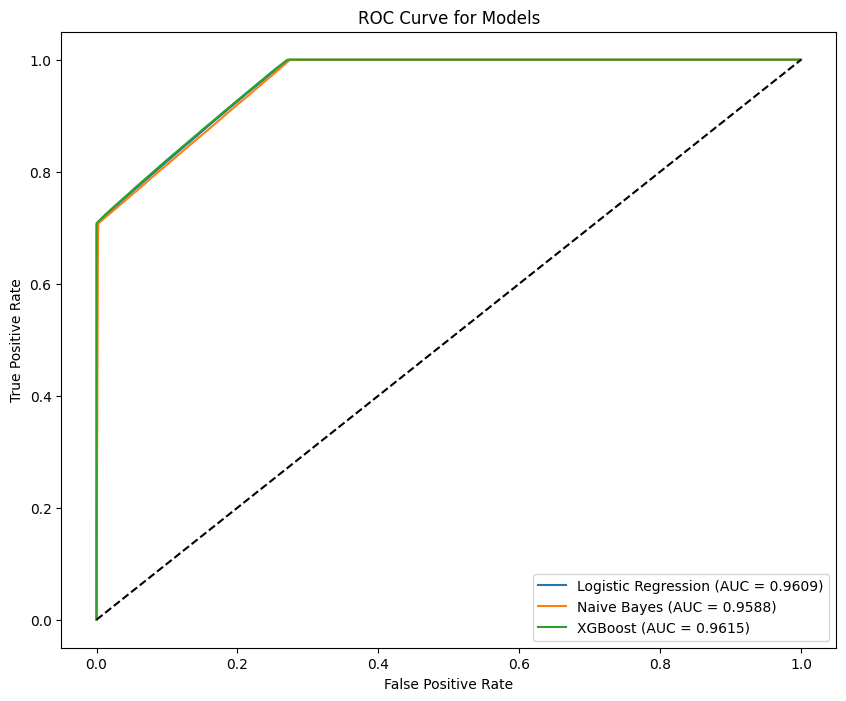

In [126]:
# Plot ROC curves for each model
plt.figure(figsize=(10, 8))
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Models')
plt.legend()
plt.show()


In [ ]:
# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GridSearchCV for XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and AUC score
print("\nBest Hyperparameters for XGBoost:")
print(grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)


In [ ]:
# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize GridSearchCV for XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and AUC score
print("\nBest Hyperparameters for XGBoost:")
print(grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x000001C91572C500>>
Traceback (most recent call last):
  File "c:\Users\HP 430 G8\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


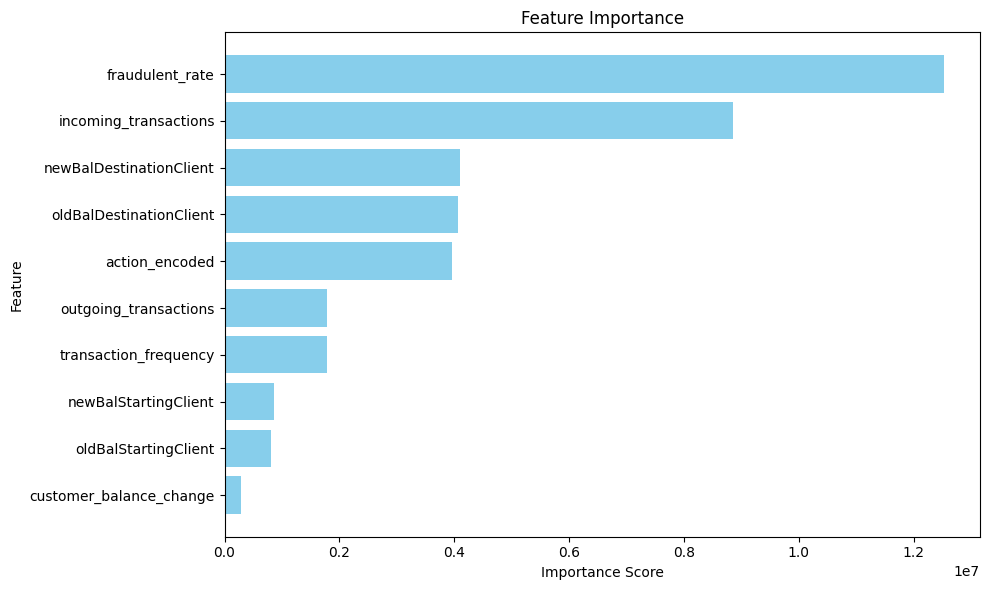

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming feature_importance_df contains the data
feature_importance_df = pd.DataFrame({
    'Feature': [
        'fraudulent_rate', 'incoming_transactions', 'newBalDestinationClient', 
        'oldBalDestinationClient', 'action_encoded', 'outgoing_transactions',
        'transaction_frequency', 'newBalStartingClient', 'oldBalStartingClient',
        'customer_balance_change'
    ],
    'Importance (Score)': [
        12528720.0, 8856059.0, 4108050.0, 4064970.0, 3961930.0, 1786900.0, 
        1786900.0, 863426.9, 802619.9, 285522.3
    ]
})

# Plot histogram
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['Feature'], 
    feature_importance_df['Importance (Score)'], 
    color='skyblue'
)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Reverse order to match importance descending
plt.tight_layout()
plt.show()
